In [98]:
#analytics
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from entropy_python_library.entropy.entropy import *
import mass_ts as mts

# visuals
import matplotlib.pyplot as plt

In [99]:

import sys
sys.path.append('../../../stumpy/my_stumpy/')
import stumpy
#window_size = 4200

#robust to window size?

## Import Condition Data

In [100]:
path = "data/useful/depresjon/"

In [101]:
    
condition = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob(path + "data/condition/*.csv")]
control = [pd.read_csv(f,header=0, index_col=0, parse_dates=True, squeeze=True) for f in glob.glob(path + "data/control/*.csv")]

In [102]:
control_mean = [np.mean(x) for x in control]
condition_mean = [np.mean(x) for x in condition]



## Extract Features

### Extracting the following features from selected data

<ol>
<li>Mean Activity Level</li>
<li>Standard Deviation</li>
<li> Trimmed Mean </li>
</ol>

In [103]:

# separate into condition and control lists
x = np.zeros(23)
y = np.ones(len(control))
index = np.hstack((x,y))
df_scores = pd.read_csv(path + 'data/scores.csv')
df_scores['group'] = index

split_scores_control = list(df_scores.groupby('group'))[1]
split_scores_condition = list(df_scores.groupby('group'))[0]

# Clean data to only include the first n days of data records
limited_control = [list(x.groupby('date'))[0:y] for x, y in zip(control,split_scores_control[1]['days'])]
limited_condition =[list(x.groupby('date'))[0:y] for x, y in zip(condition,split_scores_condition[1]['days'])]

untupled_list = []
for y in limited_control:
    untupled_list.append([x[1] for x in y])
limited_control_df = [pd.concat(x) for x in untupled_list]

untupled_list = []
for y in limited_condition:
    untupled_list.append([x[1] for x in y])
limited_condition_df = [pd.concat(x) for x in untupled_list]

In [104]:

training_data_raw = [x['activity'].values for x in limited_condition_df] + [x['activity'].values for x in limited_control_df]

In [105]:
def normalise(X):
    return [(x - min(X))/(max(X)-min(X)) for x in X]

In [106]:
y = np.asarray([1 for x in range(0,len(condition))] + [0 for x in range(0,len(control))])


In [107]:
len(condition)

23

In [108]:
len(control)

32

In [109]:
control_prototype = [x['activity'].values for x in control][0:8]
condition_prototype = [x['activity'].values for x in condition][0:6]

control_evaluate = [x['activity'].values for x in control][8:32]
condition_evaluate = [x['activity'].values for x in condition][6:23]

In [110]:
y_prototype =  np.asarray([1 for x in range(0,len(control_prototype))] + [0 for x in range(0,len(condition_prototype))])

In [111]:
y_evaluate = np.asarray([1 for x in range(0,len(control_evaluate))] + [0 for x in range(0,len(condition_evaluate))])

In [112]:
selected_window = 2500

In [113]:
def extract_top_shapelet_pair(x, window):
    time_series = np.array(x,dtype=float)
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window)
    df_matrix_profile = pd.DataFrame()
 
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['neighbour_index']= matrix_profile[:,1]
    df_matrix_profile['indexes']= df_matrix_profile.index
    top_motifs = df_matrix_profile.sort_values(by='distances')
    left_index = top_motifs['indexes'].iloc[0]
    right_index = top_motifs['indexes'].iloc[1]
    selected_subsequence = x[left_index:left_index + window_size]
    selected_partner = x[right_index:right_index + window_size]
    return(selected_subsequence, selected_partner)

In [114]:
def extract_top_shapelet(x, window):
    time_series = np.array(x,dtype=float)
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window)
    df_matrix_profile = pd.DataFrame()
 
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['neighbour_index']= matrix_profile[:,1]
    df_matrix_profile['indexes']= df_matrix_profile.index
    top_motifs = df_matrix_profile.sort_values(by='distances')
    left_index = top_motifs['indexes'].iloc[0]
    right_index = top_motifs['neighbour_index'].iloc[0]
    selected_subsequence = x[left_index:left_index + window_size]
    print(selected_subsequence)
    return(selected_subsequence)
    
    

In [115]:
control_subsequences = []
condition_subsequences = []

window_size = selected_window

for x in control_prototype:
    subsequence = extract_top_shapelet(x, window_size)
    control_subsequences.append(subsequence)
for x in condition_prototype:
    subsequence = extract_top_shapelet(x, window_size)
    condition_subsequences.append(subsequence)


[469   8   3 ...   5   5   5]
[1336 1178  372 ...  261  261  261]
[1055  990  901 ...   22   93    2]
[2341 1418  854 ...    5    5    5]
[  3   3   3 ...   5  12 758]


/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/stumpy/core.py:427: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(welford_nanvar(a, w))


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[5 5 5 ... 5 5 5]
[0 0 0 ... 0 0 0]
[396 467 325 ... 284   0   0]
[0 0 0 ... 0 0 0]
[  0   6 130 ...  44  58 125]
[249  40  14 ...   0   0   0]
[  0   0   0 ... 259 158 234]


In [116]:
import scipy

control_candidate_distances = []
condition_candidate_distances = []



for candidate in control_subsequences: 

    control_distances = []
    condition_distances = []
    for x in control_subsequences:
        distance = scipy.spatial.distance.euclidean(x, candidate)
        if distance != 0:
            control_distances.append(distance)
    control_candidate_distances.append(np.mean(control_distances))
    for x in condition_subsequences:
        distance = scipy.spatial.distance.euclidean(x, candidate)
        if distance != 0:
            condition_distances.append(distance)
    condition_candidate_distances.append(np.mean(condition_distances))

difference = np.asarray(condition_candidate_distances) - np.asarray(control_candidate_distances)
    
candidate_distance_df_control = pd.DataFrame()
candidate_distance_df_control['control_distance'] = control_candidate_distances
candidate_distance_df_control['condition_distance'] = condition_candidate_distances
candidate_distance_df_control['distance_difference'] = difference
candidate_distance_df_control['indexes'] = candidate_distance_df_control.index


sorted_candidate_df_control = candidate_distance_df_control.sort_values(by='distance_difference')
first_candidate_control = sorted_candidate_df_control['indexes'].iloc[-1]
second_candidate_control = sorted_candidate_df_control['indexes'].iloc[-2]
#print(sorted_candidate_df_control['indexes'].iloc[-2])
print(candidate_distance_df_control[candidate_distance_df_control['distance_difference']==max(candidate_distance_df_control['distance_difference'])])

   control_distance  condition_distance  distance_difference  indexes
5       7191.179111         9635.282638          2444.103527        5


In [117]:
import scipy


control_candidate_distances = []
condition_candidate_distances = []


for candidate in condition_subsequences:    
    control_distances = []
    condition_distances = []
    for x in control_subsequences:
        distance = scipy.spatial.distance.euclidean(x, candidate)
        if distance != 0:
        #print(distance)
            control_distances.append(distance)
    control_candidate_distances.append(np.mean(control_distances))
    for x in condition_subsequences:
        distance = scipy.spatial.distance.euclidean(x, candidate)
        #print(distance)
        if distance != 0:
            condition_distances.append(distance)
    condition_candidate_distances.append(np.mean(condition_distances))
    

difference = np.asarray(control_candidate_distances) - np.asarray(condition_candidate_distances)
    
candidate_distance_df_condition = pd.DataFrame()
candidate_distance_df_condition['control_distance'] = control_candidate_distances
candidate_distance_df_condition['condition_distance'] = condition_candidate_distances
candidate_distance_df_condition['distance_difference'] = difference
candidate_distance_df_condition['indexes'] = candidate_distance_df_condition.index


sorted_candidate_df_condition = candidate_distance_df_condition.sort_values(by='distance_difference')
first_candidate_condition = sorted_candidate_df_condition['indexes'].iloc[-1]
second_candidate_condition = sorted_candidate_df_condition['indexes'].iloc[-2]

candidate_distance_df_condition[candidate_distance_df_condition['distance_difference']==max(candidate_distance_df_condition['distance_difference'])]

,control_distance,condition_distance,distance_difference,indexes
4,17840.438459,16193.188679,1647.24978,4


In [118]:
#TODO what happens if its a partner

control_selected_first_candidate = control_subsequences[first_candidate_control]
control_prototype_index = first_candidate_control
condition_selected_first_candidate = condition_subsequences[first_candidate_condition]
condition_prototype_index = first_candidate_condition


In [119]:
from scipy import signal

def DP_flatness_motif(x,window):
    time_series = np.array(x,dtype=float)
    my_window = len(time_series) - window
    window_size = window # Approximately, how many data points might be found in a pattern
    matrix_profile = stumpy.stump(time_series, m=window_size)
    df_matrix_profile = pd.DataFrame()
    df_matrix_profile['distances']= matrix_profile[:,0]
    df_matrix_profile['indexes']= df_matrix_profile.index
    top_motifs = df_matrix_profile.sort_values(by='distances')[0:10]
    distance_sum = np.sum(top_motifs['distances'])
    entropy_sum = np.sum([np.log(x) for x in top_motifs['distances']])
    entropy = entropy_sum * 1/len(top_motifs['distances'])
    entropy = np.exp(entropy)
    #entropy = entropy/(distance_sum/len(top_motifs['distances']))
    return entropy

In [120]:
def subsequence_features(window):
    df_features = pd.DataFrame()
    
    mean = []
    std = []
    control_distances_first = []
    condition_distances_first = []
    control_distances_second = []
    condition_distances_second = []
    motif_entropies = []
    
    for x in control_evaluate:
        mean.append(np.mean(x))
        std.append(np.std(x))
        top_motif = extract_top_shapelet(x, window)
        #motif_entropies.append(DP_flatness_motif(x, 2500))
        
        control_distance_first = scipy.spatial.distance.euclidean(top_motif, control_selected_first_candidate)
        control_distances_first.append(control_distance_first)
        
        condition_distance_first = scipy.spatial.distance.euclidean(top_motif, condition_selected_first_candidate)
        condition_distances_first.append(condition_distance_first)

        
    for x in condition_evaluate:
        mean.append(np.mean(x))
        std.append(np.std(x))
        top_motif = extract_top_shapelet(x, window)
       # motif_entropies.append(DP_flatness_motif(x, 2500))

        
        control_distance_first = scipy.spatial.distance.euclidean(top_motif, control_selected_first_candidate)
        control_distances_first.append(control_distance_first)
        
        condition_distance_first = scipy.spatial.distance.euclidean(top_motif, condition_selected_first_candidate)
        condition_distances_first.append(condition_distance_first)

        
    df_features_train = pd.DataFrame()
    df_features_train['mean'] = normalise(mean)
    df_features_train['std'] = normalise(std)
    df_features_train['control_distance_first'] = normalise(control_distances_first)
    df_features_train['condition_distance_first'] = normalise(condition_distances_first)
    #df_features_train['motif entropy'] = normalise(motif_entropies)
    #df_features_train['control_distance_second'] = normalise(control_distances_second)
    #df_features_train['condition_distance_second'] = normalise(condition_distances_second)


    return(df_features_train.values)

In [121]:
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier 


X = subsequence_features(selected_window)

accuracy_scores = []
precision_scores = []
recall_scores = []
F1_scores = []


rfc = RandomForestClassifier(n_estimators=2200, min_samples_split=3, min_samples_leaf=1)
accuracy_scores.append(cross_val_score(rfc, X, y_evaluate, cv=10, scoring='accuracy'))
precision_scores.append(cross_val_score(rfc, X, y_evaluate, cv=10, scoring='precision_weighted'))
recall_scores.append(cross_val_score(rfc, X, y_evaluate, cv=10, scoring='recall_weighted'))
F1_scores.append(cross_val_score(rfc, X, y_evaluate, cv=10, scoring='f1_weighted'))


print(np.mean(accuracy_scores,axis=1))
print(np.mean(precision_scores,axis=1))
print(np.mean(recall_scores,axis=1))
print(np.mean(F1_scores,axis=1))


print(np.std(accuracy_scores,axis=1))
print(np.std(precision_scores,axis=1))
print(np.std(recall_scores,axis=1))
print(np.std(F1_scores,axis=1))

/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/stumpy/core.py:427: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(welford_nanvar(a, w))


[0 0 0 ... 0 0 0]
[  0   0   0 ...   0  12 184]
[1384 2668 4658 ...  568  197  259]
[  3   3  53 ... 268 268  74]
[321   0   0 ...   0   0   0]
[ 550  783  154 ...  550  425 1010]
[0 0 0 ... 0 0 0]
[  0   0   0 ... 231 313 971]
[18 55 30 ...  6 44 21]
[3 0 0 ... 0 0 0]
[174   0   0 ...   0   0   0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[3325 8000 6772 ... 1010  688 1183]
[545 545 407 ...  23   5 449]
[ 30   0   0 ... 201   0 103]
[3 3 3 ... 8 8 8]
[ 74  34  91 ... 424 945 915]
[568   0   0 ...   0   0   0]
[  49   24   37 ... 1042 1894 1260]
[336  16   5 ...   7   7   7]
[0 0 0 ... 0 0 2]
[   0    3   44 ...  321  713 1254]
[0 0 0 ... 0 0 0]
[   0    0   66 ... 1212 1212 1824]
[1386 1386 1301 ...    0    0    0]
[   0   16    0 ... 1123  930 1055]
[191 217 273 ...  26  28   0]
[ 11 386 919 ...   0   0   0]
[  9   9   9 ...   9   9 384]
[   5   50   52 ... 1102 1509 1824]
[   3    3    3 ... 2752 2284 2146]
[  0   0 394 ...   0   0   0]
[0 0 0 ... 0 0 0]
[248 464  60 ...  63 421 100]
[129

/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

[0.635]
[0.58391667]
[0.655]
[0.58928571]
[0.16286497]
[0.22086385]
[0.16948451]
[0.18161923]


## Semantic Interpretation

In [122]:
control_selected_first_candidate

array([0, 0, 0, ..., 0, 0, 0])

In [123]:
condition_selected_first_candidate

array([249,  40,  14, ...,   0,   0,   0])

4944


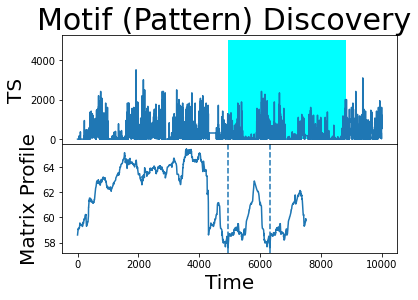

In [124]:
# Matrix profile for Condition samples

time_series = np.array(control[control_prototype_index]['activity'][0:10000],dtype=float)
matrix_profile = stumpy.stump(time_series, m=window_size)
df_matrix_profile = pd.DataFrame(matrix_profile)
df_matrix_profile['indexes'] = df_matrix_profile.index
df_matrix_profile_sorted = df_matrix_profile.sort_values(by=0)
top_motif_index1 = df_matrix_profile_sorted.iloc[0][1]
top_motif_index2 = df_matrix_profile_sorted.iloc[0]['indexes']
print(top_motif_index1)

from matplotlib.patches import Rectangle
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(control[control_prototype_index]['activity'].values[0:10000])
axs[0].set_ylabel('TS', fontsize='20')
rect = Rectangle((top_motif_index1, 0), window_size, 5000, facecolor='cyan')
axs[0].add_patch(rect)
rect = Rectangle((top_motif_index2, 0), window_size, 5000, facecolor='cyan')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=top_motif_index1, linestyle="dashed")
axs[1].axvline(x=top_motif_index2, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])

plt.show()

In [125]:
prototype_control_semantic = control[control_prototype_index][top_motif_index1:top_motif_index1 + window_size]
timestamps = prototype_control_semantic.index
prototype_control_semantic['timestamp'] = timestamps
print(prototype_control_semantic['timestamp'][0].dayofweek)
prototype_control_semantic['hour'] = [entire_timestamp.hour for entire_timestamp in timestamps]
prototype_control_semantic['day'] = [entire_timestamp.dayofyear for entire_timestamp in timestamps]
prototype_control_grouped = prototype_control_semantic.groupby(['day','hour'])['activity'].sum()

4


/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopy

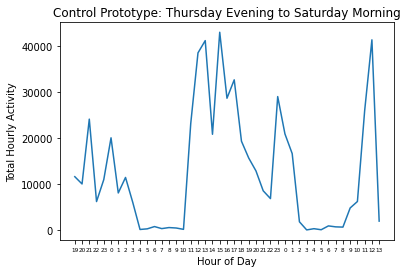

In [136]:
hours = [x[1] for x in prototype_control_grouped.index]
plt.plot(list(prototype_control_grouped))
plt.xticks(np.arange(len(hours)),hours, fontsize="xx-small")
plt.xlabel("Hour of Day")
plt.ylabel("Total Hourly Activity")
plt.title("Control Prototype: Thursday Evening to Saturday Morning")
plt.savefig('Prototype_Images/Depresjon/control.eps') 

286


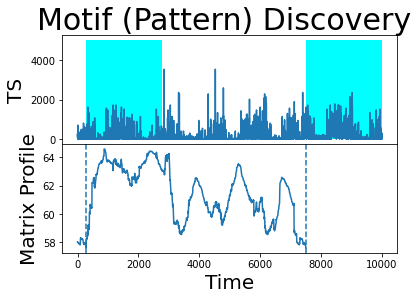

In [132]:
# Matrix profile for Condition samples

time_series = np.array(condition[condition_prototype_index]['activity'][0:10000],dtype=float)
matrix_profile = stumpy.stump(time_series, m=window_size)
df_matrix_profile = pd.DataFrame(matrix_profile)
df_matrix_profile['indexes'] = df_matrix_profile.index
df_matrix_profile_sorted = df_matrix_profile.sort_values(by=0)
top_motif_index1 = df_matrix_profile_sorted.iloc[0][1]
top_motif_index2 = df_matrix_profile_sorted.iloc[0]['indexes']
print(top_motif_index1)

from matplotlib.patches import Rectangle
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(condition[condition_prototype_index]['activity'].values[0:10000])
axs[0].set_ylabel('TS', fontsize='20')
rect = Rectangle((top_motif_index1, 0), window_size, 5000, facecolor='cyan')
axs[0].add_patch(rect)
rect = Rectangle((top_motif_index2, 0), window_size, 5000, facecolor='cyan')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=top_motif_index1, linestyle="dashed")
axs[1].axvline(x=top_motif_index2, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])

plt.show()

In [133]:
prototype_condition_semantic = condition[condition_prototype_index][top_motif_index1:top_motif_index1 + window_size]
timestamps = prototype_condition_semantic.index
prototype_condition_semantic['timestamp'] = timestamps
print(prototype_condition_semantic['timestamp'][0].dayofweek)
prototype_condition_semantic['hour'] = [entire_timestamp.hour for entire_timestamp in timestamps]
prototype_condition_semantic['day'] = [entire_timestamp.dayofyear for entire_timestamp in timestamps]
prototype_condition_grouped = prototype_condition_semantic.groupby(['day','hour'])['activity'].sum()

3


/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/tortysivill/.pyenv/versions/3.7.3/envs/entropy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopy

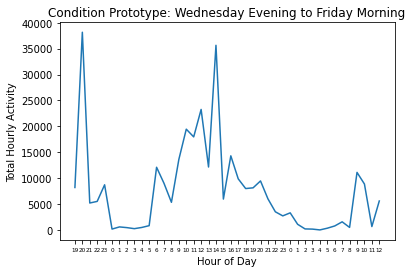

In [137]:
hours = [x[1] for x in prototype_condition_grouped.index]
plt.plot(list(prototype_condition_grouped))
plt.xticks(np.arange(len(hours)),hours, fontsize="xx-small")
plt.xlabel("Hour of Day")
plt.ylabel("Total Hourly Activity")
plt.title("Condition Prototype: Wednesday Evening to Friday Morning")
plt.savefig('Prototype_Images/Depresjon/condition.eps') 